In [1]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier

from ipywidgets import interactive
from collections import defaultdict

import hdbscan
import folium
import re

cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
        '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
        '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
        '#000075', '#808080']*10
sns.set(style="white")

In [2]:
df = pd.read_csv('twitter_posts.csv')
df.head()

Date         Username  longitude   latitude  \
0  2023-03-18 16:28:04+00:00          RokebyM  67.997691   6.622513   
1  2023-03-18 11:20:07+00:00          watwijm  94.944302  26.649359   
2  2023-03-18 11:05:10+00:00  travelwitharyan  72.206516  27.698326   
3  2023-03-18 11:03:32+00:00  travelwitharyan  72.206516  27.698326   
4  2023-03-18 08:44:42+00:00  NSivapriyan2141  77.312066   8.230492   

                city country  
0             India'   India  
1  Arunachal Pradesh   India  
2            Bikaner   India  
3            Bikaner   India  
4    Padmanabhapuram   India

In [3]:
df_filtered = df[(df.quantile(0.0001) < df) & (df < df.quantile(0.9999))]

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_77866/3662280918.py:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_filtered = df[(df.quantile(0.0001) < df) & (df < df.quantile(0.9999))]
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_77866/3662280918.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_filtered = df[(df.quantile(0.0001) < df) & (df < df.quantile(0.9999))]


In [4]:
df_filtered.head()

Date Username  longitude   latitude city country
0  NaN      NaN  67.997691   6.622513  NaN     NaN
1  NaN      NaN  94.944302  26.649359  NaN     NaN
2  NaN      NaN  72.206516  27.698326  NaN     NaN
3  NaN      NaN  72.206516  27.698326  NaN     NaN
4  NaN      NaN  77.312066   8.230492  NaN     NaN

In [5]:
df_filtered= df_filtered.drop('Date', axis=1)

In [6]:
df_filtered= df_filtered.drop('Username', axis=1)

In [7]:
df_filtered= df_filtered.drop('city',axis=1)

In [8]:
df_filtered = df_filtered.drop('country',axis=1)

In [9]:
df_filtered.head()

longitude   latitude
0  67.997691   6.622513
1  94.944302  26.649359
2  72.206516  27.698326
3  72.206516  27.698326
4  77.312066   8.230492

### Dropping NaN and Duplicates

In [10]:
print(f'Before dropping values\t:\tdf.shape = {df.shape}')
df.dropna(inplace=True)
df.drop_duplicates(subset = ['latitude','longitude'], keep='first', inplace=True)
df = df[df['country'] == 'India']
print(f'After dropping values\t:\tdf.shape = {df.shape}')

Before dropping values	:	df.shape = (1803, 6)
After dropping values	:	df.shape = (578, 6)


In [11]:
print(f'Before dropping values\t:\_filtered.shape = {df_filtered.shape}')
df_filtered.dropna(inplace=True)
df_filtered.drop_duplicates(subset = ['latitude','longitude'], keep='first', inplace=True)
# df_filtered = df_filtered[df_filtered['country'] == 'India']
print(f'After dropping values\t:\tdf_filtered.shape = {df_filtered.shape}')

Before dropping values	:\_filtered.shape = (1803, 2)
After dropping values	:	df_filtered.shape = (607, 2)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Axes: >

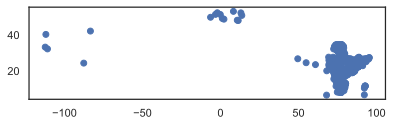

In [12]:
import geopandas as gpd
from shapely.geometry import Point


# Convert it to a GeoDataFrame by transforming the Latitude/Longitude coordinates 
loc_crs = {'init': 'epsg:4326'}
loc_geom = [Point(xy) for xy in zip(df_filtered['longitude'], df_filtered['latitude'])]
geo_df = gpd.GeoDataFrame(df_filtered, crs=loc_crs, geometry=loc_geom)

# Plot the GeoDataFrame
geo_df.plot()

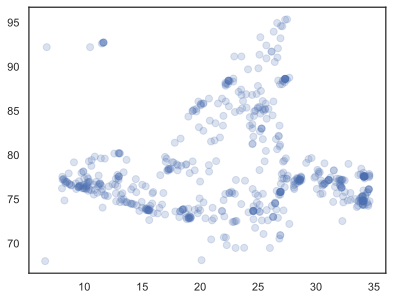

In [13]:
X = np.array(df[['latitude', 'longitude']], dtype='float64')
plt.scatter(X[:,0], X[:,1], alpha=0.2, s=50)

In [14]:
m = folium.Map(location=[df.latitude.mean(), df.longitude.mean()], zoom_start=9, tiles='OpenStreet Map')

for _, row in df.iterrows():
    folium.CircleMarker(location=[row.latitude, row.longitude], radius = 5, popup=row['city'], color = '#1787FE',fill=True, fill_colour='#1787FE').add_to(m)
    
m

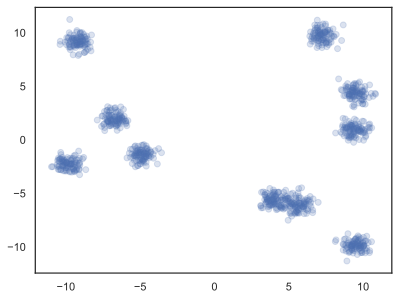

In [15]:
X_blobs,_ = make_blobs(n_samples=1000,centers=10, n_features=2, cluster_std=0.5, random_state=4)
plt.scatter(X_blobs[:,0], X_blobs[:,1], alpha = 0.2)

In [16]:
class_predictions = np.load('sample_clusters.npy')

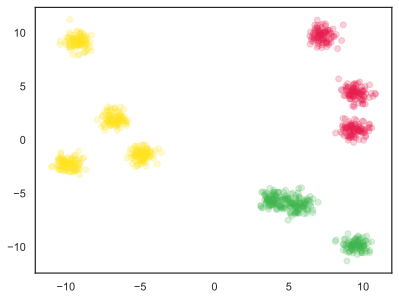

In [17]:
unique_clusters = np.unique(class_predictions)
for unique_cluster in unique_clusters:
    X = X_blobs[class_predictions==unique_cluster]
    plt.scatter(X[:,0],X[:,1], alpha=0.2, c=cols[unique_cluster])

In [18]:
silhouette_score(X_blobs,class_predictions)

0.6657220862867241

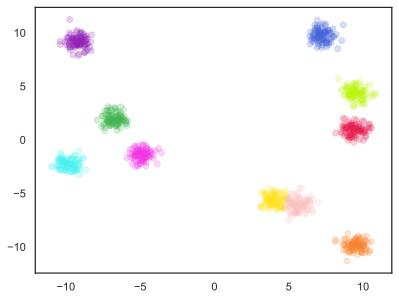

In [19]:
class_predictions = np.load('sample_clusters_improved.npy')
unique_clusters = np.unique(class_predictions)
for unique_cluster in unique_clusters:
    X = X_blobs[class_predictions==unique_cluster]
    plt.scatter(X[:,0], X[:,1], alpha=0.2, c=cols[unique_cluster])

In [20]:
silhouette_score(X_blobs,class_predictions)

0.7473587799908298

## K-Means Clustering

In [21]:
X_blobs,_ = make_blobs(n_samples=1000, centers=50, n_features=2, cluster_std=1,random_state=4)

In [22]:
data= defaultdict(dict)

for x in range(1,21):
    model = KMeans(n_clusters=3, random_state=17, max_iter=x, n_init=1).fit(X_blobs)
    
    data[x]['class_predictions'] = model.predict(X_blobs)
    data[x]['centroids'] = model.cluster_centers_
    data[x]['unique_classes'] = np.unique(class_predictions)

In [23]:
def f(x):
    
    class_predictions = data[x]['class_predictions']
    centroids = data[x]['centroids']
    unique_classes = data[x]['unique_classes']
    
    for unique_class in unique_classes:
        plt.scatter(X_blobs[class_predictions == unique_class][:,0],
                   X_blobs[class_predictions==unique_class][:,1],
                   alpha=0.3, c=cols[unique_class])
        
    plt.scatter(centroids[:,0], centroids[:,1], s=200, c='#000000', marker='v')
    plt.ylim([-15,15]); plt.xlim([-15,15])
    plt.title('How K-Means Clusters')
    

interactive_plot = interactive(f,x=(1,10))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=5, description='x', max=10, min=1), Output(layout=Layout(height='350px')…

In [24]:
X = np.array(df[['longitude', 'latitude']], dtype='float64')
k = 70
model = KMeans(n_clusters=k, random_state=17).fit(X)
class_predictions = model.predict(X)
df[f'CLUSTER_kmeans{k}'] = class_predictions

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [25]:
df['CLUSTER_kmeans70'].max()

69

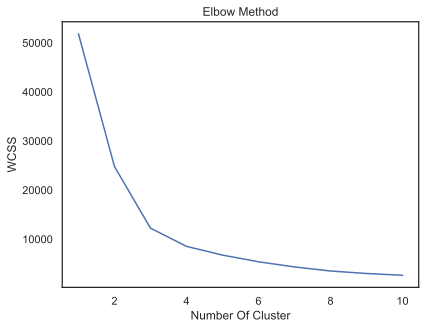

In [26]:
wcss = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300,n_init=10,random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number Of Cluster')
plt.ylabel('WCSS')
plt.show()

In [27]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)

In [28]:
df['clusters_kmeans_final'] = pred_y

In [29]:
df.head()

Date         Username  longitude   latitude  \
0  2023-03-18 16:28:04+00:00          RokebyM  67.997691   6.622513   
1  2023-03-18 11:20:07+00:00          watwijm  94.944302  26.649359   
2  2023-03-18 11:05:10+00:00  travelwitharyan  72.206516  27.698326   
4  2023-03-18 08:44:42+00:00  NSivapriyan2141  77.312066   8.230492   
5  2023-03-17 14:38:59+00:00    tourism_udupi  74.667323  13.086056   

                city country  CLUSTER_kmeans70  clusters_kmeans_final  
0             India'   India                22                      1  
1  Arunachal Pradesh   India                26                      0  
2            Bikaner   India                54                      0  
4    Padmanabhapuram   India                47                      1  
5              Udupi   India                32                      1

In [30]:
def create_map(df, cluster_column):
    m = folium.Map(location=[df.latitude.mean(), df.longitude.mean()], zoom_start=9, titles='OpenStreet Map')
    
    for _, row in df.iterrows():
        if row[cluster_column] == -1:
            cluster_color = '#000000'
        else:
            cluster_color = cols[row[cluster_column]]
        
        folium.CircleMarker(location=[row['latitude'], row['longitude']],
                           radius=5,
                           popup= row[cluster_column],
                           color=cluster_color,
                           fill=True,
                           fill_color = cluster_color).add_to(m)
    return m

m = create_map(df,'CLUSTER_kmeans70')

print(f'K={k}')
print(f'Silhouette Score: {silhouette_score(X,class_predictions)}')


K=70
Silhouette Score: 0.5316222060923381


In [31]:
test_map = create_map(df, 'clusters_kmeans_final')
print(f'Silhouette Score: {silhouette_score(X,pred_y)}')

Silhouette Score: 0.48094475845392975


In [32]:
test_map

In [33]:
m

In [34]:
best_silhouette, best_k = -1,0

for k in tqdm(range(2,100)):
    
    model = KMeans(n_clusters=k, random_state=1).fit(X)
    class_predictions = model.predict(X)
    
    curr_silhouette = silhouette_score(X,class_predictions)
    if curr_silhouette > best_silhouette:
        best_k = k
        best_silhouette = curr_silhouette

print(f'K={best_k}')
print(f'Silhouette Score: {best_silhouette}')


  0%|                                                  | 0/98 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  1%|▍                                         | 1/98 [00:00<00:11,  8.44it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  3%|█▎                  

 26%|██████████▍                              | 25/98 [00:03<00:11,  6.55it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 27%|██████████▉                              | 26/98 [00:03<00:11,  6.51it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 28%|███████████▎                             | 27/98 [00:03<00:11,  6.45it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init`

 50%|████████████████████▌                    | 49/98 [00:07<00:09,  5.00it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 51%|████████████████████▉                    | 50/98 [00:07<00:10,  4.68it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 52%|█████████████████████▎                   | 51/98 [00:07<00:10,  4.64it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init`

 74%|██████████████████████████████▌          | 73/98 [00:14<00:07,  3.18it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 76%|██████████████████████████████▉          | 74/98 [00:14<00:07,  3.17it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 77%|███████████████████████████████▍         | 75/98 [00:14<00:07,  3.21it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init`

 99%|████████████████████████████████████████▌| 97/98 [00:22<00:00,  2.63it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
100%|█████████████████████████████████████████| 98/98 [00:22<00:00,  4.32it/s]

K=3
Silhouette Score: 0.5675511314386762


### DBSCAN

In [35]:
dummy = np.array([-1, -1, -1, 2, 3, 4, 5,-1])
new = np.array([(counter+2)*x if x == -1 else x for counter, x in enumerate(dummy)])

In [36]:
model = DBSCAN(eps=0.5, min_samples=5).fit(X)
class_predictions = model.labels_
df['CLUSTERS_DBSCAN'] = class_predictions

In [37]:
m = create_map(df, 'CLUSTERS_DBSCAN')

print(f'Number of Clusters found: {len(np.unique(class_predictions))}')
print(f'Number of Outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette Ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = 0
no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

Number of Clusters found: 26
Number of Outliers found: 217
Silhouette Ignoring outliers: 0.7210836595316975
Silhouette outliers as singletons: 0.2369926515965694


In [38]:
m

### HDBSCAN

In [39]:
model = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2, cluster_selection_epsilon=0.5)

class_predictions = model.fit_predict(X)
df['CLUSTER_HDBSCAN'] = class_predictions

In [40]:
df.head()

Date         Username  longitude   latitude  \
0  2023-03-18 16:28:04+00:00          RokebyM  67.997691   6.622513   
1  2023-03-18 11:20:07+00:00          watwijm  94.944302  26.649359   
2  2023-03-18 11:05:10+00:00  travelwitharyan  72.206516  27.698326   
4  2023-03-18 08:44:42+00:00  NSivapriyan2141  77.312066   8.230492   
5  2023-03-17 14:38:59+00:00    tourism_udupi  74.667323  13.086056   

                city country  CLUSTER_kmeans70  clusters_kmeans_final  \
0             India'   India                22                      1   
1  Arunachal Pradesh   India                26                      0   
2            Bikaner   India                54                      0   
4    Padmanabhapuram   India                47                      1   
5              Udupi   India                32                      1   

   CLUSTERS_DBSCAN  CLUSTER_HDBSCAN  
0               -1               -1  
1               -1                3  
2               -1               -1  
4                0               26  
5                1               30

In [41]:
m = create_map(df, 'CLUSTER_HDBSCAN')

print(f'Number of clusters found: {len(np.unique(class_predictions))-1}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')
print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

Number of clusters found: 32
Number of outliers found: 101
Silhouette ignoring outliers: 0.591695974990947
Silhouette outliers as singletons: 0.2886665389768749


In [42]:
m

In [43]:
hdbscan.HDBSCAN?

### Addressing Outliers

In [44]:
classifier = KNeighborsClassifier(n_neighbors=1)

In [45]:
df_train = df[df.CLUSTER_HDBSCAN != 1]
df_predict = df[df.CLUSTER_HDBSCAN==-1]

In [46]:
X_train = np.array(df_train[['longitude', 'latitude']], dtype='float64')
y_train = np.array(df_train['CLUSTER_HDBSCAN'])
X_predict = np.array(df_predict[['longitude', 'latitude']], dtype='float64')

In [47]:
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [48]:
predictions = classifier.predict(X_predict)

In [49]:
df['CLUSTER_hybrid'] = df['CLUSTER_HDBSCAN']

In [50]:
df.loc[df.CLUSTER_HDBSCAN==-1, 'CLUSTER_hybrid'] = predictions

In [51]:
m = create_map(df, 'CLUSTER_hybrid')

In [52]:
m

In [53]:
df.head()

Date         Username  longitude   latitude  \
0  2023-03-18 16:28:04+00:00          RokebyM  67.997691   6.622513   
1  2023-03-18 11:20:07+00:00          watwijm  94.944302  26.649359   
2  2023-03-18 11:05:10+00:00  travelwitharyan  72.206516  27.698326   
4  2023-03-18 08:44:42+00:00  NSivapriyan2141  77.312066   8.230492   
5  2023-03-17 14:38:59+00:00    tourism_udupi  74.667323  13.086056   

                city country  CLUSTER_kmeans70  clusters_kmeans_final  \
0             India'   India                22                      1   
1  Arunachal Pradesh   India                26                      0   
2            Bikaner   India                54                      0   
4    Padmanabhapuram   India                47                      1   
5              Udupi   India                32                      1   

   CLUSTERS_DBSCAN  CLUSTER_HDBSCAN  CLUSTER_hybrid  
0               -1               -1              -1  
1               -1                3               3  
2               -1               -1              -1  
4                0               26              26  
5                1               30              30

In [54]:
class_predictions = df.CLUSTER_hybrid
print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Silhouette: {silhouette_score(X, class_predictions)}')

m.save('hybrid.html')

Number of clusters found: 33
Silhouette: 0.34895078675913704


Text(0.5, 0, 'Cluster Sizes')

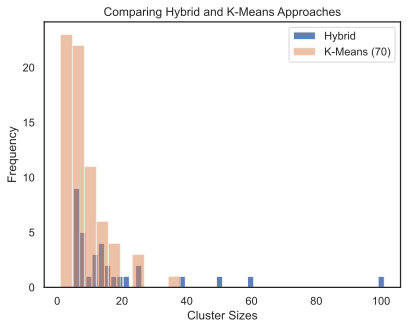

In [55]:
df['CLUSTER_hybrid'].value_counts().plot.hist(bins=50, alpha=0.9, 
                                              label='Hybrid')
df['CLUSTER_kmeans70'].value_counts().plot.hist(bins=10, alpha=0.5,
                                               label='K-Means (70)')
plt.legend()
plt.title('Comparing Hybrid and K-Means Approaches')
plt.xlabel('Cluster Sizes')

In [56]:
df.head()

Date         Username  longitude   latitude  \
0  2023-03-18 16:28:04+00:00          RokebyM  67.997691   6.622513   
1  2023-03-18 11:20:07+00:00          watwijm  94.944302  26.649359   
2  2023-03-18 11:05:10+00:00  travelwitharyan  72.206516  27.698326   
4  2023-03-18 08:44:42+00:00  NSivapriyan2141  77.312066   8.230492   
5  2023-03-17 14:38:59+00:00    tourism_udupi  74.667323  13.086056   

                city country  CLUSTER_kmeans70  clusters_kmeans_final  \
0             India'   India                22                      1   
1  Arunachal Pradesh   India                26                      0   
2            Bikaner   India                54                      0   
4    Padmanabhapuram   India                47                      1   
5              Udupi   India                32                      1   

   CLUSTERS_DBSCAN  CLUSTER_HDBSCAN  CLUSTER_hybrid  
0               -1               -1              -1  
1               -1                3               3  
2               -1               -1              -1  
4                0               26              26  
5                1               30              30

#####  Drop countries != INDIA

[0.51374453 0.48625547]


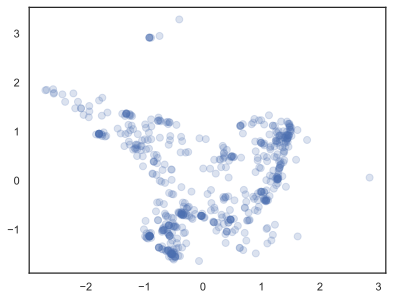

In [57]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

feature = np.array(df[['longitude', 'latitude']], dtype='float64')
labels = df['city']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

pc_df = pd.DataFrame(data=principal_components, columns=['PC1','PC2'])
pc_df['city'] = labels

print(pca.explained_variance_ratio_)
# pc_df = pc_df.sort_values(by=['PC1', 'PC2'])
# pc_df = pc_df.rolling(window=5, center=True, min_periods=1).mean()
# pc_df = pc_df.dropna()

X_pcdf = np.array(pc_df[['PC1', 'PC2']], dtype='float64')
plt.scatter(X_pcdf[:,0], X_pcdf[:,1],alpha=0.2, s=50)
# plt.figure(figsize=(50,50))
# plt.scatter(pc_df[:, 0], pc_df[:, 1], c=labels, cmap='viridis')
# sns.scatterplot(x='PC1', data=pc_df)
plt.show()

In [58]:
pc_df.head()

PC1       PC2               city
0  2.847962  0.060029             India'
1 -2.559355  1.863411  Arunachal Pradesh
2  0.388487 -1.273198            Bikaner
3  1.457053  1.161573                NaN
4  1.374018  0.370825    Padmanabhapuram

In [59]:
# from sklearn.cluster import KMeans
# from sklearn.cluster import DBSCAN
from hdbscan import HDBSCAN
# import numpy as np

def hybrid_clustering(X, k, eps, min_samples, min_cluster_size):
    # Step 1: Perform K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    # Step 2: Identify core samples and non-core samples using DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_samples_mask[dbscan.core_sample_indices_] = True
    db_labels = dbscan.labels_

    # Step 3: Perform HDBSCAN clustering on core samples
    hdbscan = HDBSCAN(min_cluster_size=min_cluster_size).fit(X[core_samples_mask])
    hdbscan_labels = hdbscan.labels_

    # Step 4: Combine cluster labels from all clustering methods
    final_labels = np.zeros_like(labels)
    for i in range(len(labels)):
        if core_samples_mask[i]:
            final_labels[i] = hdbscan_labels[np.where(np.array(kmeans.predict([X[i]])) == kmeans.labels_[i])[0][0]] + np.max(db_labels) + 1
        else:
            final_labels[i] = db_labels[i] + np.max(hdbscan.labels_) + 1
    print(f'Number of clusters found: {len(np.unique(final_labels))-1}')
    print(f'Number of outliers found: {len(final_labels[final_labels==-1])}')       
    return final_labels


In [60]:
ab = hybrid_clustering(X_pcdf,2,0.5,10,5)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters found: 2
Number of outliers found: 0


In [61]:
X_filtered = np.array(df_filtered[['longitude', 'latitude']], dtype='float64')

Number of clusters found: 2
Number of outliers found: 0


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters found: 4
Number of outliers found: 0


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters found: 8
Number of outliers found: 0
Number of clusters found: 9
Number of outliers found: 0
Number of clusters found: 11
Number of outliers found: 0


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters found: 11
Number of outliers found: 0


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters found: 13
Number of outliers found: 0


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters found: 13
Number of outliers found: 0


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters found: 13
Number of outliers found: 0


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters found: 9
Number of outliers found: 0


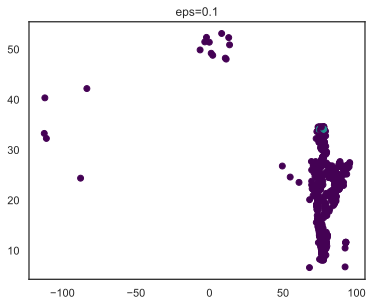

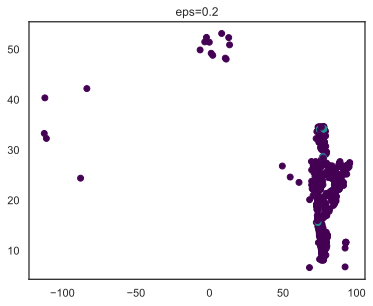

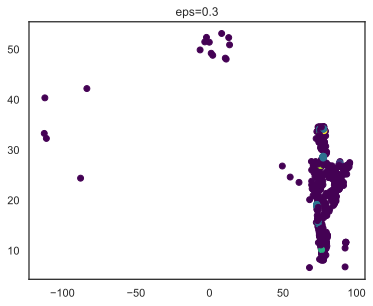

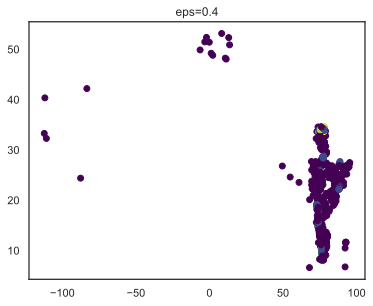

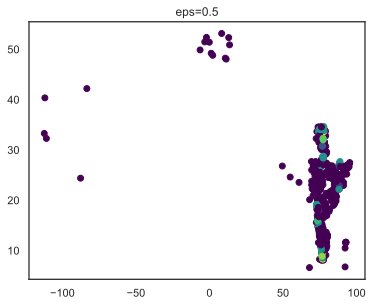

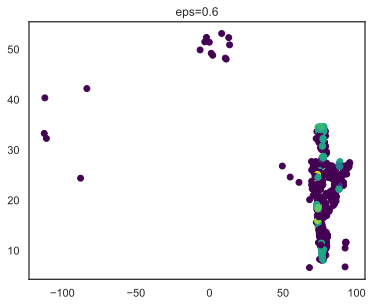

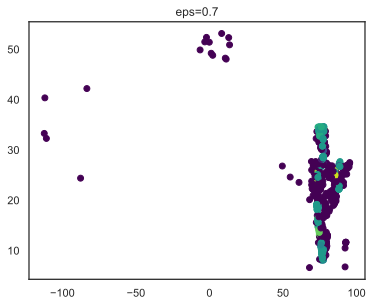

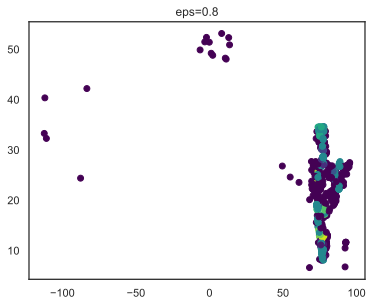

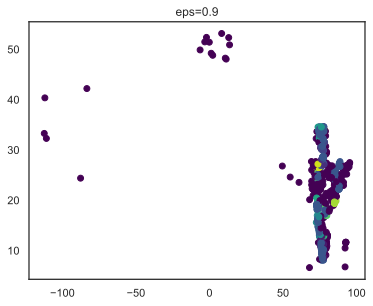

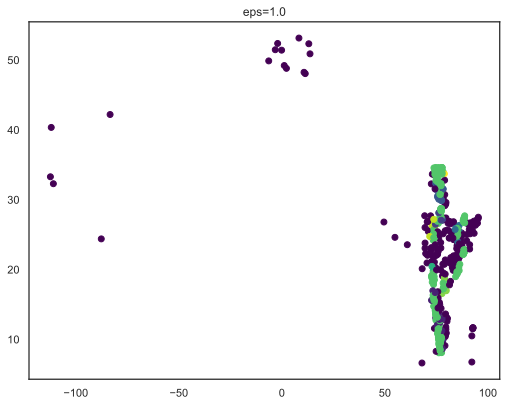

In [62]:
eps_values = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

for i, eps in enumerate(eps_values):
    hybrid_cluster = hybrid_clustering(X_filtered, 2, eps, 10, 5)
    
    plt.figure(figsize=(35,27))

    plt.subplot(5, 5, i+1)
    plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=hybrid_cluster, cmap='viridis')
    plt.title(f'eps={eps}')

plt.tight_layout()
plt.show()

In [63]:
df['hybrid_cluster'] = hybrid_clustering(X_pcdf,2,0.5,10,5)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters found: 2
Number of outliers found: 0


In [64]:
df.head(20)

Date         Username  longitude   latitude  \
0   2023-03-18 16:28:04+00:00          RokebyM  67.997691   6.622513   
1   2023-03-18 11:20:07+00:00          watwijm  94.944302  26.649359   
2   2023-03-18 11:05:10+00:00  travelwitharyan  72.206516  27.698326   
4   2023-03-18 08:44:42+00:00  NSivapriyan2141  77.312066   8.230492   
5   2023-03-17 14:38:59+00:00    tourism_udupi  74.667323  13.086056   
6   2023-03-17 12:05:03+00:00         onsvlogs  85.832496  21.544342   
8   2023-03-17 02:31:04+00:00    jaydeep_dey03  90.939097  25.722728   
9   2023-03-16 16:16:44+00:00  flywithheritage  77.882808  30.227984   
11  2023-03-16 10:07:08+00:00      Hyd_Library  78.233173  17.237105   
15  2023-03-16 05:55:10+00:00    BhanwalaVinit  76.994604  28.080602   
17  2023-03-16 01:08:13+00:00  cartoonistarvin  76.317532  32.190952   
18  2023-03-15 16:30:15+00:00    Nirajksingh21  84.956937  24.673368   
22  2023-03-15 14:39:56+00:00     raihanhaque7  88.390681  22.492584   
24  2023-03-15 14:00:58+00:00       SKesari_22  84.292829  24.286947   
26  2023-03-15 06:44:16+00:00   BBC_travelogue  87.413715  23.539988   
29  2023-03-15 04:32:53+00:00          O_arra_  76.992563  30.918767   
30  2023-03-14 19:31:11+00:00     Sudhanshu_MK  84.993910  25.483546   
31  2023-03-14 16:15:06+00:00  AJAYKUM95362816  83.331271  21.970758   
32  2023-03-14 10:26:12+00:00        vtouring1  76.938730  31.720993   
33  2023-03-14 06:33:21+00:00        regilkool  88.444115  27.137137   

                 city country  CLUSTER_kmeans70  clusters_kmeans_final  \
0              India'   India                22                      1   
1   Arunachal Pradesh   India                26                      0   
2             Bikaner   India                54                      0   
4     Padmanabhapuram   India                47                      1   
5               Udupi   India                32                      1   
6         West Bengal   India                11                      0   
8            Guwahati   India                 7                      0   
9            Dehradun   India                34                      0   
11     Rajendra Nagar   India                68                      1   
15                Nuh   India                30                      0   
17          Dharmsala   India                 0                      0   
18           Bodhgaya   India                 2                      0   
22       Bidhan Nagar   India                27                      0   
24               Gaya   India                 2                      0   
26       Santiniketan   India                51                      0   
29             Shimla   India                39                      0   
30              Patna   India                58                      0   
31          Jharkhand   India                66                      0   
32   Kullu and Manali   India                 0                      0   
33            Gangtok   India                16                      0   

    CLUSTERS_DBSCAN  CLUSTER_HDBSCAN  CLUSTER_hybrid  hybrid_cluster  
0                -1               -1              -1              26  
1                -1                3               3              27  
2                -1               -1              -1               0  
4                 0               26              26               0  
5                 1               30              30               0  
6                -1               -1              -1               0  
8                -1                3               3               0  
9                 2               18              18               0  
11                3                4               4               0  
15                4               14              14               0  
17                5               24              24               0  
18                8               28              28               0  
22                6               

In [65]:
hybrid_map = create_map(df, 'hybrid_cluster')


In [66]:
hybrid_map

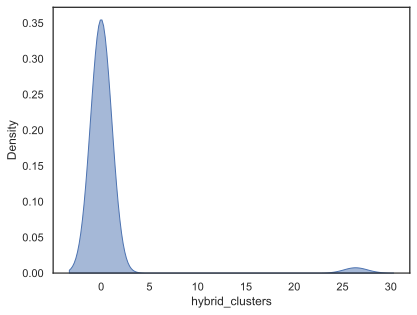

In [67]:
sns.kdeplot(data=df,x='hybrid_cluster',cmap='YlOrRd',fill=True, alpha=0.5)

# plt.title(' of Twitter Posts')
plt.xlabel('hybrid_clusters')
# plt.ylabel('Latitude')
plt.show()

Text(0.5, 0, 'Cluster Sizes')

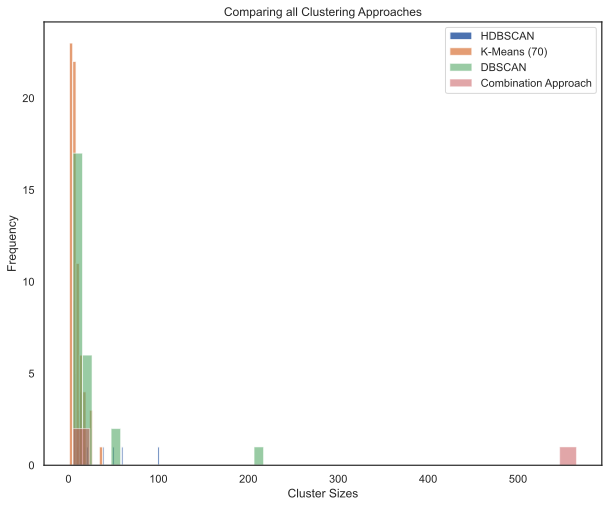

In [68]:
plt.figure(figsize=(10,8))
df['CLUSTER_hybrid'].value_counts().plot.hist(bins=50, alpha=1, 
                                              label='HDBSCAN')
df['CLUSTER_kmeans70'].value_counts().plot.hist(bins=10, alpha=0.8,
                                               label='K-Means (70)')
df['CLUSTERS_DBSCAN'].value_counts().plot.hist(bins=20, alpha=0.6, label = 'DBSCAN')

df['hybrid_cluster'].value_counts().plot.hist(bins=30, alpha=0.5, label = 'Combination Approach')

plt.legend()
plt.title('Comparing all Clustering Approaches')
plt.xlabel('Cluster Sizes')

In [69]:
df.head(20)

Date         Username  longitude   latitude  \
0   2023-03-18 16:28:04+00:00          RokebyM  67.997691   6.622513   
1   2023-03-18 11:20:07+00:00          watwijm  94.944302  26.649359   
2   2023-03-18 11:05:10+00:00  travelwitharyan  72.206516  27.698326   
4   2023-03-18 08:44:42+00:00  NSivapriyan2141  77.312066   8.230492   
5   2023-03-17 14:38:59+00:00    tourism_udupi  74.667323  13.086056   
6   2023-03-17 12:05:03+00:00         onsvlogs  85.832496  21.544342   
8   2023-03-17 02:31:04+00:00    jaydeep_dey03  90.939097  25.722728   
9   2023-03-16 16:16:44+00:00  flywithheritage  77.882808  30.227984   
11  2023-03-16 10:07:08+00:00      Hyd_Library  78.233173  17.237105   
15  2023-03-16 05:55:10+00:00    BhanwalaVinit  76.994604  28.080602   
17  2023-03-16 01:08:13+00:00  cartoonistarvin  76.317532  32.190952   
18  2023-03-15 16:30:15+00:00    Nirajksingh21  84.956937  24.673368   
22  2023-03-15 14:39:56+00:00     raihanhaque7  88.390681  22.492584   
24  2023-03-15 14:00:58+00:00       SKesari_22  84.292829  24.286947   
26  2023-03-15 06:44:16+00:00   BBC_travelogue  87.413715  23.539988   
29  2023-03-15 04:32:53+00:00          O_arra_  76.992563  30.918767   
30  2023-03-14 19:31:11+00:00     Sudhanshu_MK  84.993910  25.483546   
31  2023-03-14 16:15:06+00:00  AJAYKUM95362816  83.331271  21.970758   
32  2023-03-14 10:26:12+00:00        vtouring1  76.938730  31.720993   
33  2023-03-14 06:33:21+00:00        regilkool  88.444115  27.137137   

                 city country  CLUSTER_kmeans70  clusters_kmeans_final  \
0              India'   India                22                      1   
1   Arunachal Pradesh   India                26                      0   
2             Bikaner   India                54                      0   
4     Padmanabhapuram   India                47                      1   
5               Udupi   India                32                      1   
6         West Bengal   India                11                      0   
8            Guwahati   India                 7                      0   
9            Dehradun   India                34                      0   
11     Rajendra Nagar   India                68                      1   
15                Nuh   India                30                      0   
17          Dharmsala   India                 0                      0   
18           Bodhgaya   India                 2                      0   
22       Bidhan Nagar   India                27                      0   
24               Gaya   India                 2                      0   
26       Santiniketan   India                51                      0   
29             Shimla   India                39                      0   
30              Patna   India                58                      0   
31          Jharkhand   India                66                      0   
32   Kullu and Manali   India                 0                      0   
33            Gangtok   India                16                      0   

    CLUSTERS_DBSCAN  CLUSTER_HDBSCAN  CLUSTER_hybrid  hybrid_cluster  
0                -1               -1              -1              26  
1                -1                3               3              27  
2                -1               -1              -1               0  
4                 0               26              26               0  
5                 1               30              30               0  
6                -1               -1              -1               0  
8                -1                3               3               0  
9                 2               18              18               0  
11                3                4               4               0  
15                4               14              14               0  
17                5               24              24               0  
18                8               28              28               0  
22                6               

In [70]:
# from sklearn.neighbors import NearestNeighbors
neighbors = KNeighborsClassifier(n_neighbors=1)

df_train = df[df.CLUSTERS_DBSCAN != 1]
df_predict = df[df.CLUSTERS_DBSCAN==-1]

X_train = np.array(df_train[['longitude', 'latitude']], dtype='float64')
y_train = np.array(df_train['CLUSTERS_DBSCAN'])
X_predict = np.array(df_predict[['longitude', 'latitude']], dtype='float64')

In [71]:
neighbors.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [72]:
predictions_dbscan = neighbors.predict(X_predict)

In [73]:
neighbors_hdbcan = KNeighborsClassifier(n_neighbors=1)

df_train_hd = df[df.CLUSTER_HDBSCAN != 1]
df_predict_hd = df[df.CLUSTER_HDBSCAN== -1]

X_train_hd = np.array(df_train_hd[['longitude', 'latitude']], dtype='float64')
y_train_hd = np.array(df_train_hd['CLUSTER_HDBSCAN'])
X_predict_hd = np.array(df_predict_hd[['longitude', 'latitude']], dtype='float64')

In [74]:
neighbors_hdbcan.fit(X_train_hd, y_train_hd)

KNeighborsClassifier(n_neighbors=1)

In [75]:
predictions_hdbscan = neighbors_hdbcan.predict(X_predict_hd)

In [76]:
neighbors_hybrid = KNeighborsClassifier(n_neighbors=1)

df_train_hybrid = df[df.hybrid_cluster != 1]
df_predict_hybrid = df[df.hybrid_cluster == -1]

X_train_hybrid = np.array(df_train_hybrid[['longitude', 'latitude']], dtype='float64')
y_train_hybrid = np.array(df_train_hybrid['hybrid_cluster'])
X_predict_hybrid = np.array(df_predict_hybrid[['longitude', 'latitude']], dtype='float64')

In [77]:
neighbors_hybrid.fit(X_train_hybrid,y_train_hybrid)

KNeighborsClassifier(n_neighbors=1)

In [78]:
# predictions_hybrid = neighbors_hybrid.predict(X_predict_hybrid)

In [79]:
from scipy.spatial.distance import cdist
def calculate_rmse(X,labels_true, labels_pred):
    
    centroids_true = np.array([np.mean(X[labels_true == i], axis=0) for i in set(labels_true)])
    centroids_pred = np.array([np.mean(X[labels_pred == i], axis=0) for i in set(labels_pred)])
    dist_matrix = cdist(centroids_true, centroids_pred)
    matching = np.array([[i,j] for i in range(dist_matrix.shape[0]) for j in range(dist_matrix.shape[1]) if dist_matrix[i,j] == np.min(dist_matrix)])
    rmse = np.sqrt(np.mean(np.square(np.linalg.norm(centroids_true[matching[:,0]] - centroids_pred[matching[:,1]], axis =1))))
    return rmse



In [80]:
labels_kmeans = KMeans(n_clusters=3, random_state=0).fit_predict(X_pcdf)
labels_dbscan = DBSCAN(eps=0.5, min_samples=10).fit_predict(X_pcdf)
labels_hdbscan = hdbscan.HDBSCAN(min_samples=10).fit_predict(X_pcdf)
labels_hybrid = hybrid_clustering(X_pcdf,k=2,eps=0.5,min_samples=10,min_cluster_size=5)

labels_true= labels_kmeans

rmse_kmeans = calculate_rmse(X_filtered,labels_true,labels_kmeans)
rmse_dbscan = calculate_rmse(X_filtered, labels_true, labels_dbscan)
rmse_hdbscan = calculate_rmse(X_filtered, labels_true,labels_hdbscan)
rmse_hybrid = calculate_rmse(X_filtered, labels_true , labels_hybrid)

print("RMSE for KMeans: {:.4f}".format(rmse_kmeans))
print("RMSE for DBSCAN: {:.4f}".format(rmse_dbscan))
print("RMSE for HDBSCAN: {:.4f}".format(rmse_hdbscan))
print("RMSE for hybrid clustering: {:.4f}".format(rmse_hybrid))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters found: 2
Number of outliers found: 0


IndexError: boolean index did not match indexed array along dimension 0; dimension is 607 but corresponding boolean dimension is 578

In [81]:
# Silhouette score
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

kmeans_silhouette = silhouette_score(X_pcdf, labels_kmeans)
dbscan_silhouette = silhouette_score(X_pcdf, labels_dbscan)
hdbscan_silhouette = silhouette_score(X_pcdf, labels_hdbscan)
hybrid_silhouette = silhouette_score(X_pcdf, labels_hybrid)

print("K-Means silhouette score: ",kmeans_silhouette)
print("DBSCAN silhouette score: ",dbscan_silhouette)
print("HDBSCAN silhouette score: ",hdbscan_silhouette)
print("Hybrid model silhouette score: ",hybrid_silhouette)

K-Means silhouette score:  0.5759926885122115
DBSCAN silhouette score:  0.4426308479537479
HDBSCAN silhouette score:  0.1944203417249657
Hybrid model silhouette score:  0.36956107511441827


In [82]:
# Harbarsz Calinski score

kmeans_calinski = calinski_harabasz_score(X_pcdf, labels_kmeans)
dbscan_calinski = calinski_harabasz_score(X_pcdf, labels_dbscan)
hdbscan_calinski = calinski_harabasz_score(X_pcdf, labels_hdbscan)
hybrid_calinski = calinski_harabasz_score(X_pcdf, labels_hybrid)

print("K-Means Calinski-Harabasz Score: ", kmeans_calinski)
print("DBSCAN Calinski-Harabasz Score: ", dbscan_calinski)
print("HDBSCAN Calinski-Harabasz Score: ", hdbscan_calinski)
print("Hybrid Calinski-Harabasz Score: ", hybrid_calinski)

K-Means Calinski-Harabasz Score:  946.2464555356901
DBSCAN Calinski-Harabasz Score:  29.473224827913008
HDBSCAN Calinski-Harabasz Score:  60.876681742386786
Hybrid Calinski-Harabasz Score:  16.893930177629386


### NLP lcustering analysis

In [ ]:
nlp_places_df = pd.read_csv('Locations.csv')
nlp_places_df.head()

In [ ]:
print(f'Before dropping values\t:\tnlp_places_df.shape = {nlp_places_df.shape}')
nlp_places_df.dropna(inplace=True)
nlp_places_df.drop_duplicates(subset = ['Place'], keep='first', inplace=True)
print(f'After dropping values\t:\tnlp_places_df.shape = {nlp_places_df.shape}')

In [ ]:
test_df = nlp_places_df

In [ ]:
import geopy
from geopy.geocoders import Nominatim
import time

df_new = pd.DataFrame(columns=['longitude', 'latitude', 'City'])

geolocator = Nominatim(user_agent="my-app")
for index, row in nlp_places_df.iterrows():
    city = row['Place']
    while True:
        try:
            location = geolocator.geocode(city, timeout=10)
            if location:
                longitude = location.longitude
                latitude = location.latitude
                df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
        
            break
        except geopy.exc.GeocoderUnavailable:
            print('Geocoder is unavailable. Waiting for 5 seconds before trying again...')
            time.sleep(5)
    
        


In [ ]:
df_new.head(20)

In [ ]:
df_new.shape

In [ ]:
# np.savetxt("Locations.csv", df_new, delimiter=", ", fmt="%s")

In [ ]:
final_dataframe = pd.read_csv('Locations.csv')

In [ ]:
final_dataframe.head()

In [ ]:
final_dataframe['Cluster_HDBSCAN'] = model.fit_predict(final_dataframe[['longitude', 'latitude']])

In [ ]:
final_dataframe.head(20)

In [ ]:
final_df_train = final_dataframe[final_dataframe.Cluster_HDBSCAN != 1]
final_df_predict = final_dataframe[final_dataframe.Cluster_HDBSCAN==-1]

In [ ]:
X_train_predict = np.array(final_df_train[['longitude', 'latitude']], dtype='float64')
y_train_predict = np.array(final_df_train['Cluster_HDBSCAN'])
X_predict_final = np.array(final_df_predict[['longitude', 'latitude']], dtype='float64')

In [ ]:
classifier.fit(X_train_predict, y_train_predict)

In [ ]:
final_predictions = classifier.predict(X_predict_final)

In [ ]:
final_dataframe['CLUSTER_hybrid'] = final_dataframe['Cluster_HDBSCAN']

In [ ]:
final_dataframe.loc[final_dataframe.Cluster_HDBSCAN==-1, 'CLUSTER_hybrid'] = final_predictions

In [ ]:
import json
folium_map = folium.Map(location=[final_dataframe['latitude'].mean(), final_dataframe['longitude'].mean()], zoom_start=10, tiles='OpenStreet Map')

marker_group = folium.FeatureGroup(name = 'Markers')
for i, row in final_dataframe.iterrows():
    folium.Marker([row['latitude'], row['longitude']], popup=row['Place']).add_to(marker_group)
    
marker_group.add_to(folium_map)


cluster_geos = {}
for cluster_id in final_dataframe['CLUSTER_hybrid'].unique():
    cluster_name = f'Cluster {cluster_id}'
    cluster_features = []
    for i, row in final_dataframe[final_dataframe['CLUSTER_hybrid'] == cluster_id].iterrows():
        features = {
            'type':'Feature',
            'geometry':{'type': 'Point', 'coordinates': [row['longitude'], row['latitude']]
                       },
            'properties': {
                'name': row['Place']
            }
        }
        cluster_features.append(features)
    cluster_geo = {
        'type':'FeatureCollection',
        'feature': cluster_features
    }
    cluster_geos[cluster_name] = cluster_geo
    
    
    

search_box = '<input type="text" placeholder="Enter a city name" oninput="search(this.value)">'
html = f'<div style="position:absolute; z-index:9999; background-color:white; padding:10px">{search_box}</div>'

folium_map.get_root().html.add_child(folium.Element(html))

js = """
    function search(value) {
        console.log('Searching for:', value);

        // Hide all clusters
        Object.keys(clusterGroups).forEach(function(key) {
            clusterGroups[key].removeFrom(map);
        });
        
        

        // Show the cluster that matches the search value
        var matches = markers.filter(function(marker) {
            return marker.options.alt.indexOf(value) >= 0;
        });
        if (matches.length > 0) {
            var clusterName = matches[0].options.title;
            console.log('Match found:', clusterName);
            var geojson = clusterGeos[clusterName];
            console.log('GeoJSON:', geojson);
            var clusterGroup = L.geoJSON(geojson);
            console.log('Cluster group:', clusterGroup);
            clusterGroup.addTo(map);
            map.fitBounds(clusterGroup.getBounds());
        }
    }
    
    function onkeyup(e) {
        console.log('Keyup event:', e);

        if (e.keyCode == 13) {
            console.log('Enter key pressed');
            var value = e.target.value;
            console.log('Search value:', value);
            search(value);
        }
    }
"""
folium_map.get_root().script.add_child(folium.Element(js))
js_variable = "var clusterGroups = {};".format(json.dumps({name: json.dumps(geo) for name, geo in cluster_geos.items()}))
folium_map.get_root().script.add_child(folium.Element(js_variable))
folium_map.save('this_is_it.html')

In [ ]:
# def filter_clusters(city):
#     filtered_dataframe = final_dataframe[final_dataframe['Place'] == city]
#     if len(filtered_dataframe) == 0:
#         return None
    
#     cluster = filtered_dataframe['CLUSTER_hybrid'].iloc[0]
#     layer_name = f'Cluster {CLUSTER_hybrid}'
    
#     if layer_name not in folium_map._children:
#         cluster_layer = folium.FeatureGroup(name=layer_name)
#         for i, row in filtered_dataframe.iterrows():
#             folium.Marker([row['latitude'], row['longitude']], popup=row['Place']).add_to(cluster_layer)
        
#         folium_map.add_child(cluster_layer)
    
#     else:
#         cluster_layer = folium_map._children(layer_name)
    
#     for layer in folium_map._children.values():
#         if layer != cluster_layer:
#             folium_map.get_root().remove_child(layer)
            
    
#     folium_map.fit_bounds(cluster_layer.get_bounds())
#     folium.LayerControl().add_to(folium_map)